<a href="https://colab.research.google.com/github/gb-lcro/poisson/blob/main/pinn_adapt_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyvista

In [2]:
try:
    import ngsolve
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/ngsolve-install-real.sh" -O "/tmp/ngsolve-install.sh" && bash "/tmp/ngsolve-install.sh"
    import ngsolve

In [3]:
from netgen.occ import *
from ngsolve import *
from ngsolve.webgui import Draw
import os
import pyvista as pv
import numpy as np
import torch

directory = './images/'

In [4]:
def BaseShape(l, w):
    wp1 = WorkPlane().RectangleC(l,w).Face()
    wp2 = WorkPlane().RectangleC(w,l).Face()
    cross = wp1 + wp2
    return cross


l = 0.5
w = 1.5
base = BaseShape(l, w)

In [5]:
offset = 3
figure = base
for i in range(3):
    for j in range(3):
        if (i+j) % 2 == 0:
            figure += BaseShape(i,j).Move((i*offset, j*offset, 0))
        else:
            if i+j == 1:
                figure += WorkPlane().Circle(1).Face().Move((i*offset, j*offset, 0))
            else:
                figure += base.Mirror(Axis((0, 0, 0), (0, 1, 0))
                      ).Move((i*offset, j*offset, 0))


geo = WorkPlane().Rectangle(5,5).Face() -  figure.Move((-2,-2,0))

geo.edges.Min(Y).name ='bottom'
geo.edges.Max(Y).name ='top'
geo.edges.Min(X).name ='left'
geo.edges.Max(X).name ='right'

#Draw(geo)

In [6]:
plate = OCCGeometry(geo, dim=2)
mesh = Mesh(plate.GenerateMesh(maxh=0.5)).Curve(3)

mesh_point_count_0 = len(mesh.vertices)
vertex_coordinate_0 = []

for v in mesh.vertices:
    vertex_coordinate_0.append(v.point)

    mesh_x, mesh_y = zip(*vertex_coordinate_0) # separate tuple (veritces (x,y)) into two lists mexh_x and mesh_y
    mesh_x = np.array(mesh_x)
    mesh_y = np.array(mesh_y)

    vertex_coordinates_0 = [mesh_x, mesh_y]  ## a list containing 2 numpy arrays

#print(mesh_point_count_0)
print(mesh_y.shape,type(mesh_y))
print(mesh_x.shape,type(mesh_x))
print(len(vertex_coordinates_0),type(vertex_coordinates_0))
#Draw (mesh);

(112,) <class 'numpy.ndarray'>
(112,) <class 'numpy.ndarray'>
2 <class 'list'>


In [7]:
def solve_FEM():
    # H1-conforming finite element space
    fes = H1(mesh, order=1, dirichlet="bottom", autoupdate=True)
    # define trial- and test-functions
    u = fes.TrialFunction()
    v = fes.TestFunction()

    # the bilinear-form
    a = BilinearForm(grad(u)*grad(v)*dx)

    funcf = 1*x*y
    # funcf = 50*sin(y)
    f = LinearForm(funcf*v*dx)

    a.Assemble()
    f.Assemble()
    # Draw(funcf,mesh)
    gfu = GridFunction(fes)
    gfu.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec
    return gfu, fes

In [8]:
def export_vertex_coordinates(mesh):
    vertex_coordinates = []

    for v in mesh.vertices:
        vertex_coordinates.append(v.point)

    vertex_array = torch.tensor(np.array(vertex_coordinates))

    return vertex_array

In [9]:
vertex_array = export_vertex_coordinates(mesh)

print(type(vertex_array), vertex_array[:5], len(vertex_array))

<class 'torch.Tensor'> tensor([[0.0000, 5.0000],
        [0.0000, 0.0000],
        [3.0000, 5.0000],
        [3.0000, 3.0000],
        [5.0000, 3.0000]], dtype=torch.float64) 112


In [10]:
def export_fem_solution(mesh, gfu):
    vertex_array = export_vertex_coordinates(mesh).to(torch.float32)
    mesh_x , mesh_y = vertex_array.T
    solution_array =  torch.tensor([x for x in gfu.vec])
    return solution_array

In [11]:
gfu, fes = solve_FEM()
print(len(gfu.vec), type(gfu.vec))
print(gfu.vec[:5])


112 <class 'ngsolve.la.BaseVector'>
 67.1141
       0
 77.6094
 59.7978
 59.0125




In [12]:
solution_values = np.array(gfu.vec)
print(solution_values)

[67.11411951  0.         77.6093826  59.79775988 59.01250028  0.
  7.25261333  8.22288099 38.10660525 35.93006683 15.14923812  8.99056577
 41.20360307 46.83902497 51.97444686 49.47772205 42.89482844 35.89526816
 14.93488438  8.83801958  2.55365478  2.60272675 66.41007796 62.28243651
 74.22008465 74.51415877 74.30823288 69.13555606 67.07776968 64.79081664
 57.01918148 55.19212537 53.75909775 57.73812839 65.77046331 60.91541573
 55.28766105 51.73743709 47.37859431 41.57742639 33.73493223 21.47091887
  9.0005468  77.4478525  76.60803588 75.36164592 71.8755403  68.40569238
 76.60424602 72.87823247 67.35029021 57.61783077 57.95708393 58.59500893
 10.19273572 28.33006643 45.79982039 53.27736364 57.43753806  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          3.891009   23.66895928 41.49249136 21.55066072
 54.28229702 51.25888049 47.46698399 75.81207458 73.78979386 69.67105179
 63.72932506 56.14356521 56.47943667 57.29441688 57.70394962 51.44442283
 5

In [13]:
#Draw(gfu, mesh, "Solution")


In [14]:
print(type(fes))
print(fes.ndof)
print(fes.mesh)
print(fes.FreeDofs())
print(fes.type)

<class 'ngsolve.comp.H1'>
112
0: 10111011111111111111111111111111111111111111111111
50: 11111111100000000011111111111111111111111111111111
100: 111111111111
h1ho


In [15]:
vertex_array  = export_vertex_coordinates(mesh)
solution_array = export_fem_solution(mesh,gfu)
mesh_x , mesh_y = vertex_array.T
print(vertex_array[:5], len(vertex_array))
print(type(mesh_x), mesh_x[:5], len(mesh_x))
print(type(mesh_y), mesh_y[:5], len(mesh_y))
print(type(solution_array), solution_array[:5], len(solution_array))

tensor([[0.0000, 5.0000],
        [0.0000, 0.0000],
        [3.0000, 5.0000],
        [3.0000, 3.0000],
        [5.0000, 3.0000]], dtype=torch.float64) 112
<class 'torch.Tensor'> tensor([0., 0., 3., 3., 5.], dtype=torch.float64) 112
<class 'torch.Tensor'> tensor([5.0000, 0.0000, 5.0000, 3.0000, 3.0000], dtype=torch.float64) 112
<class 'torch.Tensor'> tensor([67.1141,  0.0000, 77.6094, 59.7978, 59.0125]) 112


In [16]:
import torch
import numpy as np
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
from matplotlib.markers import MarkerStyle
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [17]:
batch_size = 100  ## vary batch size

# Step 2: Create a TensorDataset
dataset = TensorDataset(vertex_array, solution_array.reshape(-1,1))

# Step 3: Create a DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [18]:
class FeedForward(nn.Module):

    def __init__(self, mesh_x, mesh_y):
        super(FeedForward, self).__init__()

        self.total_error_history = []
        self.boundary_error_history = []
        self.train_loss_history = []
        self.total_residual_history = []
        self.boundary_residual_history = []

        self.mesh_point_history = [vertex_coordinates_0]
        self.mesh_point_count_history = [mesh_point_count_0]

        self.optimizer = None

        # weights for the total loss function
        self.w_data     = 0.01   #loss_data
        self.w_interior = 10      #loss_interior
        self.w_bc       = 10      #loss_bc

        self.hidden_size = 50
        self.num_data = 10
        self.num_bd = 50

        # 2 input features
        self.b1 = nn.Linear(2, self.hidden_size)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.b3 = nn.Linear(self.hidden_size, 1)

        # initialize weights
        nn.init.xavier_uniform_(self.b1.weight)
        nn.init.xavier_uniform_(self.b2.weight)
        nn.init.xavier_uniform_(self.b3.weight)

        self.mesh_x  = mesh_x
        self.mesh_y  = mesh_y

    def forward(self, x, y):

        xy = torch.stack((x, y), dim=1)

        h1 = torch.tanh(self.b1(xy))
        h2 = torch.tanh(self.b2(h1))
        u = self.b3(h2)

        return u


    def compute_derivative(self, u, x, n):
        # General formula to compute the n-th order derivative of u = f(x) with respect to x
        if n == 0:
            return u
        else:
            du_dx = torch.autograd.grad(u, x, torch.ones_like(u).to(device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]

        return self.compute_derivative(du_dx, x, n - 1)


    def PDE_residual(self, x, y, use_meshgrid = False):
        if use_meshgrid:

            X,Y = torch.meshgrid(x,y)
            xy = torch.stack((X.flatten(), Y.flatten()), dim=1)

        x = torch.tensor(x, dtype=torch.float32).to(device)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        x.requires_grad=True
        y.requires_grad=True

        u = self.forward(x, y)

        d2u_dx2 = self.compute_derivative(u, x, 2)
        d2u_dy2 = self.compute_derivative(u, y, 2)

        residual = d2u_dx2 + d2u_dy2 + x*y
        return residual


    def loss_data(self):
        # xy, u = next(iter(dataloader))
        torch.manual_seed(42)
        idx = torch.randint(len(dataset), (self.num_data,))
        xy, u = dataset[idx]

        x, y  = xy.unbind(axis=1)

        x = torch.tensor(x, dtype=torch.float32).to(device)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        u = torch.tensor(u, dtype=torch.float32).to(device)

        u_pred = self.forward(x, y)
        loss_data = torch.mean(torch.square(u - u_pred))
        return loss_data


    def loss_interior(self):
        res = self.PDE_residual(self.mesh_x, self.mesh_y)
        loss_residual = torch.mean(torch.square(res))
        return loss_residual


    def loss_boundary_condition(self):

        self.x_bottom = torch.linspace(0, 5, self.num_bd).reshape(-1)
        self.y_bottom = torch.zeros(1, self.num_bd).reshape(-1)

        bc_pred_bottom = self.forward(self.x_bottom.to(device), self.y_bottom.to(device))
        loss_bc_bottom = torch.mean(torch.square(bc_pred_bottom))

        loss_bc = loss_bc_bottom
        return loss_bc


    def compute_losses(self):
        loss_interior = self.loss_interior()
        loss_data = self.loss_data()
        loss_bc = self.loss_boundary_condition()
        return loss_interior, loss_data, loss_bc


    def closure(self):
        self.optimizer.zero_grad()
        loss_interior, loss_data, loss_bc = self.compute_losses()
        total_loss = self.w_data * loss_data + self.w_interior * loss_interior + self.w_bc * loss_bc
        total_loss.backward(retain_graph=True)
        return total_loss


    def get_training_history(self):
        loss_hist = np.array(self.train_loss_history)
        total_loss, loss_bc, loss_interior, loss_data = np.split(loss_hist, 4, axis=1)
        return total_loss, loss_bc, loss_interior, loss_data


    def plot_pinn_losses(self):
            total_loss, loss_interior, loss_data, loss_bc = self.get_training_history()

            plt.figure(figsize=(8, 6))

            plt.subplot(2, 2, 1)
            plt.plot(total_loss, marker=MarkerStyle('o', fillstyle='none'), color='black', label='Total Loss')
            plt.yscale('log')
            plt.legend()

            plt.subplot(2, 2, 2)
            plt.plot(loss_bc, marker=MarkerStyle('o', fillstyle='none'), color='red', label='Boundary Condition Loss')
            plt.yscale('log')
            plt.legend()

            plt.subplot(2, 2, 3)
            plt.plot(loss_interior, marker=MarkerStyle('o', fillstyle='none'), color='blue', label='Interior Loss')
            plt.yscale('log')
            plt.legend()

            plt.subplot(2, 2, 4)
            plt.plot(loss_data, marker=MarkerStyle('o', fillstyle='none'), color='green', label='Data Loss')
            plt.yscale('log')
            plt.legend()

            plt.tight_layout()
            plt.show()

    def plot_pde_residuals(self):
            plt.figure(figsize=(15, 4))

            plt.subplot(1, 3, 1)
            plt.plot(self.mesh_point_count_history, marker=MarkerStyle('o', fillstyle='none'), color='black', label='mesh point count')
            plt.legend()

            plt.subplot(1, 3, 2)
            plt.plot(self.total_residual_history, marker=MarkerStyle('o', fillstyle='none'), color='red', label='total residual')
            plt.yscale('log')
            plt.legend()

            plt.subplot(1, 3, 3)
            plt.plot(self.boundary_residual_history, marker=MarkerStyle('o', fillstyle='none'), color='red', label='boundary residual')
            plt.yscale('log')
            plt.legend()

            plt.tight_layout()
            plt.show()

    def plot_model_error(self):
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.total_error_history, marker=MarkerStyle('o', fillstyle='none'), color='black', label='total error')
        plt.yscale('log')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.boundary_error_history, marker=MarkerStyle('o', fillstyle='none'), color='red', label='boundary error')
        plt.yscale('log')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = FeedForward(mesh_x=mesh_x, mesh_y = mesh_y).to(device)
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

cpu
FeedForward(
  (b1): Linear(in_features=2, out_features=50, bias=True)
  (b2): Linear(in_features=50, out_features=50, bias=True)
  (b3): Linear(in_features=50, out_features=1, bias=True)
)
Params: 2751


In [20]:
def train(self, epochs, optimizer='Adam', w_interior=1, w_bc=10, w_data=0.01, **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer == 'L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        # Training loop
        for epoch in range(epochs+1):
            self.optimizer.step(self.closure)

            # track progress and accumulate loss data for plotting
            if epoch % 1000 == 0:
                loss_interior, loss_data, loss_bc = self.compute_losses()
                total_loss = loss_interior + loss_bc

                self.train_loss_history.append([total_loss.cpu().detach().numpy(),
                                                loss_interior.cpu().detach().numpy(),
                                                loss_data.cpu().detach().numpy(),
                                                loss_bc.cpu().detach().numpy(),

                                                ])

                print(f'Epoch ({optimizer}): {epoch}, Total PINN Loss: {total_loss.detach().cpu().numpy()}')

In [21]:
def export_to_png(mesh, gfu, fieldname, filename, size=600):
    vtk = VTKOutput(mesh,coefs=[gfu],names=[fieldname],filename="./vtk_export",subdivision=0)
    vtk.Do()

    # Read the VTU file
    meshpv = pv.read("./vtk_export.vtu")


    # Step 2: Check if the "sol" field exists
    if fieldname in meshpv.point_data:

        plotter = pv.Plotter(window_size=[size, size])
        plotter.add_mesh(meshpv, scalars=fieldname, show_scalar_bar=True, cmap='bwr')
        plotter.add_mesh(meshpv, color="white", style="wireframe", show_scalar_bar=False)
        plotter.view_xy()
        plotter.scalar_bar.SetPosition(0.85, 0.15)  # Position (x, y) between 0 and 1
        plotter.scalar_bar.SetOrientationToVertical()
        plotter.scalar_bar.SetWidth(0.05)
        plotter.scalar_bar.SetHeight(0.7)
        # plotter.scalar_bar.SetLabelFormat("%-#6.0f")
        plotter.scalar_bar.SetLabelFormat("%2.2e")

        plotter.show(screenshot=directory+filename)

In [22]:
export = False

## Need to understand what this is doing clearly

def get_model_error(model, mesh, gfu):
    u_pred = model.forward(model.mesh_x.to(device).float(), model.mesh_y.to(device).float())
    u_pred = u_pred.detach().cpu().numpy()
    u_plot = GridFunction(fes)
    u_plot.vec[:] = BaseVector(u_pred.flatten())

    if not os.path.exists(directory): # Create the directory if it does not exist
        os.makedirs(directory)

    error = (u_plot - gfu)*(u_plot - gfu) ## compares a solution value u(x,y) from pinn and fe_solution
                                          # at the same point?

    ## I think there may be an issue with model_error and total_error.
    #  how do they differ?
    model_error = Integrate(error, mesh, VOL, element_wise=True)
    total_error = Integrate(error, mesh, VOL)  ##
    boundary_error = Integrate(error, mesh, BND)


    model.total_error_history.append(total_error)
    model.boundary_error_history.append(boundary_error)

    if export:
        export_to_png(mesh,(u_plot - gfu)*(u_plot - gfu),
                      fieldname = 'errors',
                      filename =  'errors_'+str(iteration))


In [23]:
def refine_mesh(model, fe_space, mesh):
    res = model.PDE_residual(model.mesh_x, model.mesh_y).detach().numpy()
    residuals = GridFunction(fe_space)
    residuals.vec[:] = BaseVector(res.flatten())
    residuals = (residuals)*(residuals) #integrate not element-wise but over entire domain to get one number
    eta2 = Integrate(residuals, mesh, VOL, element_wise=True)

    total_residual = Integrate(residuals, mesh, VOL)
    boundary_residual = Integrate(residuals, mesh, BND)

    maxerr = max(eta2)
    #Draw(residuals, mesh)

    model.boundary_residual_history.append(boundary_residual)
    model.total_residual_history.append(total_residual)

    if export:
        export_to_png(mesh, residuals ,
                      fieldname = 'residuals',
                      filename =  'residuals_'+str(iteration))

    # mark for refinement (vectorized alternative)
    mesh.ngmesh.Elements2D().NumPy()["refine"] = eta2.NumPy() > 0.25*maxerr
    mesh.Refine()

    '''
    #coordinates of new mesh are placed into mesh_x and mesh_y
    #not returned but updated and stored in list
    new_mesh_x, new_mesh_y = export_vertex_coordinates(mesh).unbind(1)

    new_mesh_x = new_mesh_x.numpy()
    new_mesh_y = new_mesh_y.numpy()


    old_mesh_x = model.mesh_x.numpy()
    old_mesh_y = model.mesh_y.numpy()

    new_x_points = torch.tensor(np.setdiff1d(new_mesh_x, old_mesh_x)).to(device)
    new_y_points = torch.tensor(np.setdiff1d(new_mesh_y, old_mesh_y)).to(device)

    model.mesh_x = new_mesh_x   #new_x_points  #new_mesh_x
    model.mesh_y = new_mesh_y   #new_y_points  #new_mesh_y

    # Append to history
    model.mesh_point_history.append((new_mesh_x, new_mesh_y))
    model.mesh_point_count_history.append(len(new_x_points))

    print(new_x_points.shape)
    '''
    #coordinates of new mesh are placed into mesh_x and mesh_y
    #not returned but updated and stored in list
    mesh_x, mesh_y = export_vertex_coordinates(mesh).unbind(1)
    model.mesh_x = mesh_x
    model.mesh_y = mesh_y


    # Append to history
    model.mesh_point_history.append((model.mesh_x.numpy(), model.mesh_y.numpy()))
    model.mesh_point_count_history.append(len(model.mesh_x))

In [24]:
epochs = 2000
iterations = 10

In [25]:
def adapt_mesh_and_train(model, mesh):
    fe_solution, fe_space = solve_FEM() #uses mesh
    train(model, epochs, lr=1e-3) # train pinn model on mesh points
    get_model_error(model, mesh, fe_solution) # compare pinn predictions to fe_solution to get eta2
    refine_mesh(model, fe_space, mesh) # refine mesh based on pinn error relative to fe_solution
                                       # refinement at location of large errors

In [26]:
for iteration in range(iterations):
    print(f"Iteration number: {iteration + 1}")
    adapt_mesh_and_train(model, mesh)
    print()

Iteration number: 1
Epoch (Adam): 0, Total PINN Loss: 38.32734298706055
Epoch (Adam): 1000, Total PINN Loss: 0.013752461411058903
Epoch (Adam): 2000, Total PINN Loss: 0.005466983653604984

Iteration number: 2
Epoch (Adam): 0, Total PINN Loss: 0.252623587846756
Epoch (Adam): 1000, Total PINN Loss: 0.004648837260901928
Epoch (Adam): 2000, Total PINN Loss: 0.001199397025629878

Iteration number: 3
Epoch (Adam): 0, Total PINN Loss: 0.32760074734687805
Epoch (Adam): 1000, Total PINN Loss: 0.0015612426213920116
Epoch (Adam): 2000, Total PINN Loss: 0.0005468581221066415

Iteration number: 4
Epoch (Adam): 0, Total PINN Loss: 0.7196847200393677
Epoch (Adam): 1000, Total PINN Loss: 0.0008601902518421412
Epoch (Adam): 2000, Total PINN Loss: 0.0004884859663434327

Iteration number: 5
Epoch (Adam): 0, Total PINN Loss: 1.0415529012680054
Epoch (Adam): 1000, Total PINN Loss: 0.00035480113001540303
Epoch (Adam): 2000, Total PINN Loss: 0.0013073896989226341

Iteration number: 6
Epoch (Adam): 0, Total P

In [27]:
def get_random_points(mesh, random_point_count=1_000):
    random_points = []

    for i in range(random_point_count):
        # Generate random (x,y) coordinates in the domain [0, 5]
        x, y = np.random.uniform(0, 5), np.random.uniform(0, 5)

        # Check if the generated point (x,y) is in the domain
        if not mesh(x,y).nr == -1:
            random_points.append((x, y))

    rand_points = np.array(random_points)
    rand_x, rand_y = rand_points.T

    return rand_x, rand_y

In [28]:
def get_random_model_error(model, mesh, gfu, mesh_x, mesh_y):
    #make predictions at the points (mesh_x, mesh_y)


    u_pred = model.forward(mesh_x.to(device).float(), mesh_y.to(device).float())
    u_pred = u_pred.detach().cpu().numpy()
    u_plot = GridFunction(fes)
    u_plot.vec[:] = BaseVector(u_pred.flatten()) #places prediction values (u_pred) onto the
                                                 #fe_space? a value at a mesh point or something else?

    if not os.path.exists(directory): # Create the directory if it does not exist
        os.makedirs(directory)

    error = (u_plot - gfu)*(u_plot - gfu) #this is the difference at each of many locations? gfu = final mesh of adaptive process
                                          #difference at mesh points or something else?
    model_error = Integrate(error, mesh, VOL, element_wise=True) #over the whole surface
                                                                 #sum over difference at locations

    ## should error be model_error? if not why do we want model_error?
    total_error = Integrate(error, mesh, VOL)
    boundary_error = Integrate(error, mesh, BND) ## these are boundary points of the mesh all around
                                                 ##


    res = model.PDE_residual(mesh_x, mesh_y).detach().numpy()
    residuals = GridFunction(fes)
    residuals.vec[:] = BaseVector(res.flatten())
    residuals = (residuals)*(residuals) #integrate not element-wise but over entire domain to get one number

    total_residual = Integrate(residuals, mesh, VOL)
    boundary_residual = Integrate(residuals, mesh, BND)

    model.total_error_history.append(total_error)
    model.boundary_error_history.append(boundary_error)
    model.total_residual_history.append(total_residual)
    model.boundary_residual_history.append(boundary_residual)


    if export:
        export_to_png(mesh,(u_plot - gfu)*(u_plot - gfu),
                      fieldname = 'errors',
                      filename =  'errors_'+str(iteration))

    #return total_error_history, boundary_error_history

In [29]:
rand_x, rand_y = get_random_points(mesh=mesh,
                                   random_point_count=model.mesh_point_count_history[0])
rand_model = FeedForward(rand_x, rand_y)



for iteration in range(iterations):
    print(f"Iteration number: {iteration + 1}")
    train_x, train_y = get_random_points(mesh=mesh,
                                   random_point_count=model.mesh_point_count_history[iteration])
    rand_model.mesh_x = train_x
    rand_model.mesh_y = train_y

    train(rand_model, epochs, lr=1e-3)

    eval_x = torch.tensor(model.mesh_point_history[-1][0])
    eval_y = torch.tensor(model.mesh_point_history[-1][1])

    rand_model.mesh_point_count_history.append(len(rand_model.mesh_x))
    get_random_model_error(rand_model, mesh, gfu, eval_x, eval_y)

    print()

Iteration number: 1
Epoch (Adam): 0, Total PINN Loss: 34.28076934814453
Epoch (Adam): 1000, Total PINN Loss: 0.019406158477067947
Epoch (Adam): 2000, Total PINN Loss: 0.005080534145236015

Iteration number: 2
Epoch (Adam): 0, Total PINN Loss: 44.52583312988281
Epoch (Adam): 1000, Total PINN Loss: 0.028380708768963814
Epoch (Adam): 2000, Total PINN Loss: 0.010675689205527306

Iteration number: 3
Epoch (Adam): 0, Total PINN Loss: 8.59700870513916
Epoch (Adam): 1000, Total PINN Loss: 0.01609841361641884
Epoch (Adam): 2000, Total PINN Loss: 0.005237622186541557

Iteration number: 4
Epoch (Adam): 0, Total PINN Loss: 5.632741451263428
Epoch (Adam): 1000, Total PINN Loss: 0.005696857813745737
Epoch (Adam): 2000, Total PINN Loss: 0.002839589025825262

Iteration number: 5
Epoch (Adam): 0, Total PINN Loss: 0.8336313366889954
Epoch (Adam): 1000, Total PINN Loss: 0.008605140261352062
Epoch (Adam): 2000, Total PINN Loss: 0.0015839936677366495

Iteration number: 6
Epoch (Adam): 0, Total PINN Loss: 0

In [30]:
'''
def plot_all_errors(models, labels):
    plt.figure(figsize=(10, 4))
    plt.subplot(2, 2, 1)

    for i,model in enumerate(models) :

        plt.plot(model.total_error_history, label=labels[i])
        plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.title('total error history')

    plt.subplot(2, 2, 2)
    for i,model in enumerate(models) :
        plt.plot(model.boundary_error_history, label=labels[i])
        plt.yscale('log')

    plt.title('boundary error history')
    plt.legend()
    plt.tight_layout()

    plt.subplot(2, 2, 3)
    for i,model in enumerate(models) :
        plt.plot(model.total_residual_history, label=labels[i])
        plt.yscale('log')

    plt.title('total residual history')
    plt.legend()
    plt.tight_layout()

    plt.subplot(2, 2, 4)
    for i,model in enumerate(models) :
        plt.plot(model.boundary_residual_history, label=labels[i])
        plt.yscale('log')

    plt.title('boundary residual history')
    plt.legend()
    plt.tight_layout()
    plt.show()
'''

"\ndef plot_all_errors(models, labels):\n    plt.figure(figsize=(10, 4))\n    plt.subplot(2, 2, 1)\n\n    for i,model in enumerate(models) :\n\n        plt.plot(model.total_error_history, label=labels[i])\n        plt.yscale('log')\n    plt.legend()\n    plt.tight_layout()\n    plt.title('total error history')\n\n    plt.subplot(2, 2, 2)\n    for i,model in enumerate(models) :\n        plt.plot(model.boundary_error_history, label=labels[i])\n        plt.yscale('log')\n\n    plt.title('boundary error history')\n    plt.legend()\n    plt.tight_layout()\n\n    plt.subplot(2, 2, 3)\n    for i,model in enumerate(models) :\n        plt.plot(model.total_residual_history, label=labels[i])\n        plt.yscale('log')\n\n    plt.title('total residual history')\n    plt.legend()\n    plt.tight_layout()\n\n    plt.subplot(2, 2, 4)\n    for i,model in enumerate(models) :\n        plt.plot(model.boundary_residual_history, label=labels[i])\n        plt.yscale('log')\n\n    plt.title('boundary residual

In [31]:
def plot_all_errors(models, labels):
    # Calculate global y-axis limits across all data
    max_y = float('-inf')
    min_y = float('inf')
    for model in models:
        all_values = []  # Initialize as an empty list
        for attr in ['total_error_history', 'boundary_error_history',
                     'total_residual_history', 'boundary_residual_history']:
            values = getattr(model, attr, [])  # Get attribute value, default to [] if not found
            all_values.extend(values)  # Extend all_values with the attribute values

        if all_values:  # Check if all_values is not empty
            max_y = max(max_y, max(all_values))
            min_y = min(min_y, min(all_values))

    # Ensure limits are reasonable for a log scale
    if min_y <= 0:  # Log scale can't handle values <= 0
        min_y = 1e-6  # Set to a very small positive number

    y_limits = (min_y, max_y)  # Common y-axis limits

    plt.figure(figsize=(10, 8))

    # Plot total error history
    plt.subplot(2, 2, 1)
    for i, model in enumerate(models):
        plt.plot(model.total_error_history, label=labels[i])
    plt.yscale('log')
    plt.ylim(y_limits)  # Apply global y-axis limits
    plt.title('Total Error History')
    plt.legend()
    plt.tight_layout()

    # Plot boundary error history
    plt.subplot(2, 2, 2)
    for i, model in enumerate(models):
        plt.plot(model.boundary_error_history, label=labels[i])
    plt.yscale('log')
    plt.ylim(y_limits)  # Apply global y-axis limits
    plt.title('Boundary Error History')
    plt.legend()
    plt.tight_layout()

    # Plot total residual history
    plt.subplot(2, 2, 3)
    for i, model in enumerate(models):
        plt.plot(model.total_residual_history, label=labels[i])
    plt.yscale('log')
    plt.ylim(y_limits)  # Apply global y-axis limits
    plt.title('Total Residual History')
    plt.legend()
    plt.tight_layout()

    # Plot boundary residual history
    plt.subplot(2, 2, 4)
    for i, model in enumerate(models):
        plt.plot(model.boundary_residual_history, label=labels[i])
    plt.yscale('log')
    plt.ylim(y_limits)  # Apply global y-axis limits
    plt.title('Boundary Residual History')
    plt.legend()
    plt.tight_layout()

    plt.show()


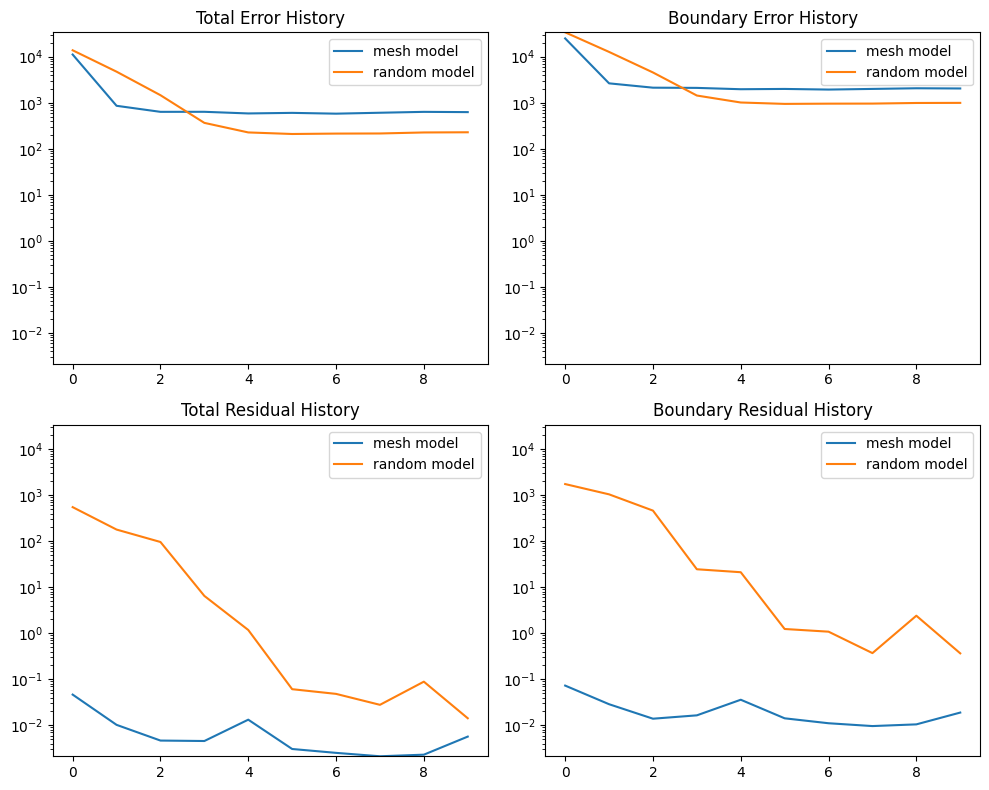

In [32]:
plot_all_errors([model, rand_model], ['mesh model', 'random model'])